# <center>TRAFFIC SIGNS CLASSIFICATION</center>

<img src="chart.jpg">

## NOTEBOOK IMPORTS

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import random
import pickle
import cv2

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## DATA IMPORTS

In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs.git

In [ ]:
!ls german-traffic-signs/

In [25]:
np.random.seed(0)

In [44]:
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
    
with open('german-traffic-signs/valid.p', 'rb') as f:
    valid_data = pickle.load(f)
    
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)
    

x_train, y_train = train_data['features'], train_data['labels']
x_valid, y_valid = valid_data['features'], valid_data['labels']
x_test, y_test = test_data['features'], test_data['labels']


print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print()
print("x_valid: ", x_valid.shape)
print("y_valid: ", y_valid.shape)
print()
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

x_train:  (34799, 32, 32, 3)
y_train:  (34799,)

x_valid:  (4410, 32, 32, 3)
y_valid:  (4410,)

x_test:  (12630, 32, 32, 3)
y_test:  (12630,)


In [12]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
data.head(10)

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


## DATA IMPORT ERROR CHECKS

In [5]:
assert(x_train.shape[0] == y_train.shape[0]), "TRAIN :Number of Images is NOT EQUAL to Number of Labels"
assert(x_valid.shape[0] == y_valid.shape[0]), "VALIDATION: Number of Images is NOT EQUAL to Number of Labels"
assert(x_test.shape[0] == y_test.shape[0]), "TEST: Number of Images is NOT EQUAL to Number of Labels"

assert(x_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(x_valid.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(x_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

## DATA VISUALIZATION

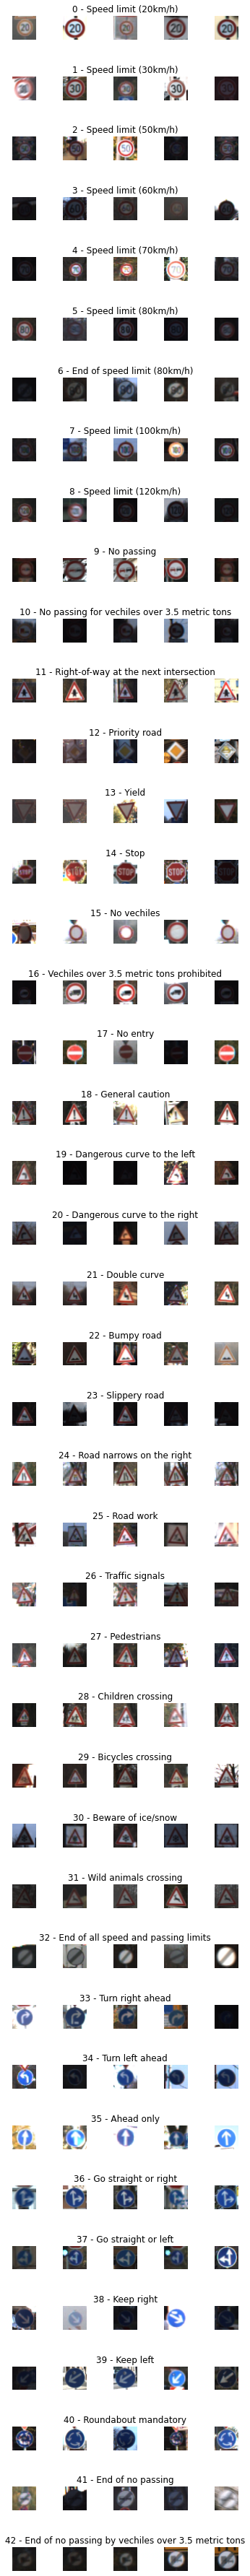

In [6]:
num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

# iterrows -- (index, Series) # ClassId, SignName 

for i in range(cols):

    for j, row in data.iterrows():

        x_selected = x_train[y_train == j]

        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        
        if i == 2:
            axs[j][i].set_title(str(j) + " - " + row["SignName"])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


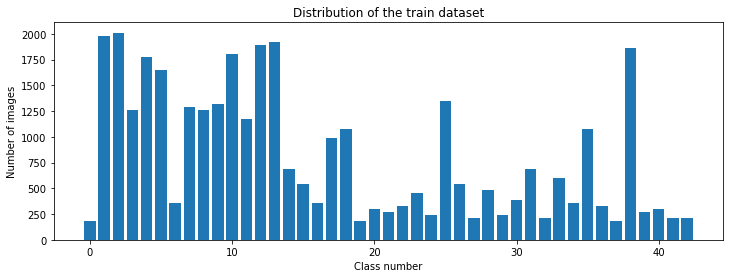

In [7]:
print(num_of_samples)

plt.figure(figsize=(12, 4))

plt.bar(range(0, num_classes), num_of_samples)
plt.xticks()

plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

plt.show()

## IMAGE PREPROCESSING

Shape:  (32, 32, 3)
Label:  ()


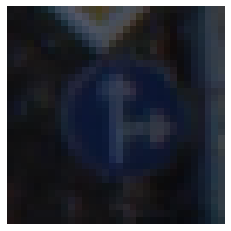

In [8]:
# Random Image

plt.imshow(x_train[1000])
print('Shape: ', x_train[1000].shape)
print('Label: ', y_train[1000].shape)
plt.axis('off')
plt.show()

#### CONVERTING TO GRAYSCALE AND HISTOGRAM EQUALIZATION
    On viewing the image by a car/computer color is not that important. Because edges and the signs are pretty much important. By grayscale image, we can reduce the channel from 3 to 1 and also focus on important features
    
    To have a similar lighting effect, we use the histogram equalization method.It simple takes the histogram of the image and spread it to get a high range of brightness value. This helps in normalize the lighting effects. That is any grayscale intensities are distributed across the image.

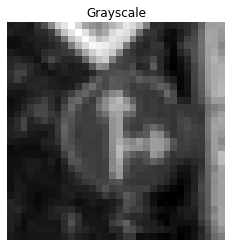

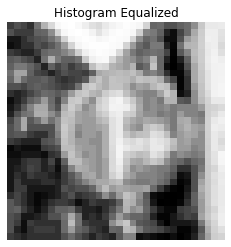

(32, 32)


In [45]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

# this function only accepts grayscale image
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

img_gray = grayscale(x_train[1000])
img_hist = equalize(grayscale(x_train[1000]))

plt.imshow(img_gray, cmap='gray')
plt.title('Grayscale')
plt.axis('off')
plt.show()

plt.imshow(img_hist, cmap='gray')
plt.title('Histogram Equalized')
plt.axis('off')
plt.show()

print(img_gray.shape)

In [9]:
# Combining the above two functions into one

def preprocessing_image(img):
    img = grayscale(img)
    img = equalize(img)
    img = img / 255.0
    return img

In [11]:
# Apply the function to all data

x_train_pro = np.array(list(map(preprocessing_image, x_train)))
x_valid_pro = np.array(list(map(preprocessing_image, x_valid)))
x_test_pro = np.array(list(map(preprocessing_image, x_test)))

#### ADDING CHANNEL VALUE TO EACH IMAGES

In [12]:
x_train_pro = x_train_pro.reshape(-1, 32, 32, 1)
x_valid_pro = x_valid_pro.reshape(-1, 32, 32, 1)
x_test_pro = x_test_pro.reshape(-1, 32, 32, 1)

print(x_train_pro.shape)
print(x_valid_pro.shape)
print(x_test_pro.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


## DATAGENERATOR CREATION
     The datagenerator is an iterator which only returns batches of transformed images when requested
     does not perform operations on all the images in the datasets, that would be very memory consuming
     It only creates the augmented images only when requested


In [13]:
data_generator = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    rotation_range=10
)

data_generator.fit(x_train_pro)

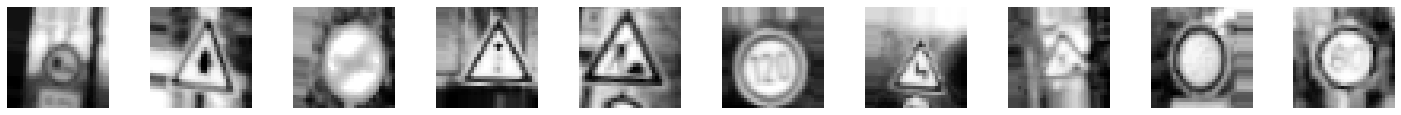

In [14]:
# requesting for the images
# on calling the function, it returns 20 images

batches = data_generator.flow(x_train_pro, y_train, batch_size=20)

x_batch, y_batch = next(batches)

fig, ax = plt.subplots(1, 10, figsize=(20, 5))
fig.tight_layout()

for i in range(10):
    ax[i].imshow(x_batch[i].reshape(32, 32), cmap='gray')
    ax[i].axis('off')

## TARGET VALUES ENCODING

In [15]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_valid = to_categorical(y_valid, 43)

## MODEL BUILDING

In [21]:
def the_model():

    model = Sequential()

    model.add(Conv2D(60, (5,5), input_shape=(32, 32, 1), activation='relu'))
    model.add(Conv2D(60, (5,5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(30, (3,3), activation='relu'))
    model.add(Conv2D(30, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())

    model.add(Dense(500, activation='relu'))

    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    
    return model

In [26]:
model = the_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 480)              

## TRAINING MODEL

In [28]:
h = model.fit(
    data_generator.flow(x_train_pro, y_train, batch_size=50),
    steps_per_epoch=len(x_train_pro) // 50,
    epochs=10,
    validation_data = (x_valid_pro, y_valid),
    shuffle=True
)

Epoch 1/10
695/695 [==============================] - 328s 472ms/step - loss: 1.8947 - accuracy: 0.4610 - val_loss: 0.4543 - val_accuracy: 0.8628
Epoch 2/10
695/695 [==============================] - 296s 425ms/step - loss: 0.7061 - accuracy: 0.7826 - val_loss: 0.1785 - val_accuracy: 0.9449
Epoch 3/10
695/695 [==============================] - 324s 466ms/step - loss: 0.4411 - accuracy: 0.8617 - val_loss: 0.1314 - val_accuracy: 0.9526
Epoch 4/10
695/695 [==============================] - 344s 495ms/step - loss: 0.3280 - accuracy: 0.8972 - val_loss: 0.1198 - val_accuracy: 0.9635
Epoch 5/10
695/695 [==============================] - 365s 525ms/step - loss: 0.2650 - accuracy: 0.9176 - val_loss: 0.0779 - val_accuracy: 0.9764
Epoch 6/10
695/695 [==============================] - 287s 413ms/step - loss: 0.2210 - accuracy: 0.9325 - val_loss: 0.0778 - val_accuracy: 0.9794
Epoch 7/10
695/695 [==============================] - 275s 396ms/step - loss: 0.1943 - accuracy: 0.9392 - val_loss: 0.0555 -

## LOSS AND ACCURACY

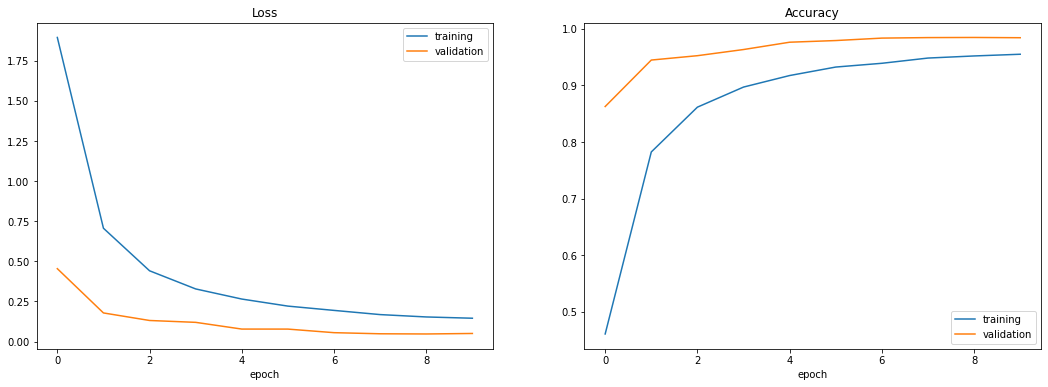

In [36]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')


plt.subplot(1, 2, 2)
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

In [31]:
score = model.evaluate(x_test_pro, y_test, verbose=1)

print('Score: ', score[0])
print('Accuracy: ', score[1])

395/395 [==============================] - 30s 77ms/step - loss: 0.1521 - accuracy: 0.9622
Score:  0.1521022468805313
Accuracy:  0.9621536135673523


## SAVING TRAINED MODEL

In [54]:
model.save('road-sign-classifier.h5')

# LOADING SAVED MODEL

In [5]:
model = tf.keras.models.load_model('road-sign-classifier.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 480)              

## TESTING OUR MODEL

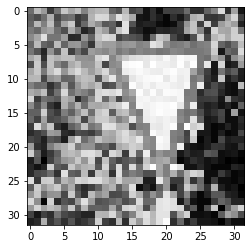

In [41]:
# https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg
# https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg
# https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg
# https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg
# https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg

import requests
from PIL import Image

url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
r = requests.get(url, stream=True)

org_img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.show()

(32, 32)


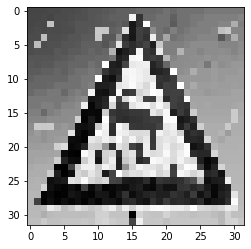

In [42]:
# Preprocess image

# converting to array
img = np.asarray(org_img)

# resize to 32X32
img = cv2.resize(img, (32, 32))

# grayscale -- equalize -- normalize
img = preprocessing_image(img)

plt.imshow(img, cmap = plt.get_cmap('gray'))

print(img.shape)

Prediction  : 23
Probability : 99.86%
Class       : Slippery road


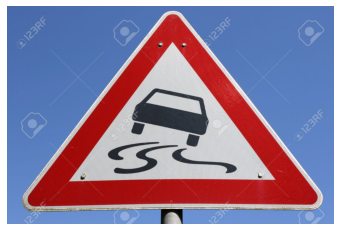

In [43]:
# reshape it for our model
reshape_img = img.reshape(1, 32, 32, 1)

# Prediction by model
prediction = np.argmax(model.predict(reshape_img), axis=-1)
probability = np.max(model.predict(reshape_img)) * 100

print(f'Prediction  : {prediction[0]}')
print(f'Probability : {round(probability, 2)}%')
print(f'Class       : {data.loc[prediction[0]][1]}')

plt.imshow(org_img, cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

## TESTING ON WEB CAM

    We can copy this code below to a python script and run inside a terminal

In [ ]:
################### NOTEBOOK IMPORTS ###################

import numpy as np
import pandas as pd

import cv2
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

################# IMPORTING DATA AND MODEL #################

label = pd.read_csv('german-traffic-signs/signnames.csv')
classifier = tf.keras.models.load_model('road-sign-classifier.h5')
test_image = 'test-images/30.png'

######################## SETTING CAM ########################

frameWidth= 640         
frameHeight = 480

brightness = 180
threshold = 0.75

font = cv2.FONT_HERSHEY_SIMPLEX

cap = cv2.VideoCapture(test_image)
cap.set(3, frameWidth)
cap.set(4, frameHeight)
cap.set(10, brightness)

####################### HELPER FUNCTIONS ######################

def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

def preprocessing_image(img):
    img = grayscale(img)
    img = equalize(img)
    img = img / 255.0
    return img

while True:
    
    ret, frame = cap.read()
    
    img = np.asarray(frame)
    img = cv2.resize(img, (32, 32))
    img = preprocessing_image(img)
    img = img.reshape(1, 32, 32, 1)
    
    cv2.putText(frame, "CLASS: " , (20, 35), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(frame, "PROBABILITY: ", (20, 75), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
    
    prediction = np.argmax(classifier.predict(img), axis=-1)
    probability = np.max(classifier.predict(img))
    
    if probability > threshold:
        class_name = label.loc[prediction[0]][1]
        
        cv2.putText(frame, str(class_name), (120, 35), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
        cv2.putText(frame, str(round(probability * 100, 2) ) + "%", (180, 75), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
        
        cv2.imshow("Result", frame)

    if cv2.waitKey(10) and 0xFF == ord('q'):
        break
    